In [3]:
require(tidyverse)
require(data.table)

##  2. load data &  bin data

In [4]:
dat.pro_ps<- fread("../dat/1901/alpha_beta.promoter.long_matrix_w_transcripts_ps.txt")

### ps.range
ps.range <- list()
ps.range$alpha <- range((dat.pro_ps %>%filter(cluster %in% c("alpha_1","alpha_2")))$ps)
ps.range$beta <- range((dat.pro_ps %>%filter(cluster %in% c("beta_1","beta_2")))$ps)
ps.range

$alpha
[1] 0.000000 6.746176

$beta
[1]  0.0000 20.2079

In [5]:
dim(dat.pro_ps)

[1] 19412387        4

In [6]:
N.bin<- 21
ps.bks <- list()
ps.bks$alpha <- seq(ps.range$alpha[1],ps.range$alpha[2],length.out = N.bin)
ps.bks$beta <- seq(ps.range$beta[1],ps.range$beta[2],length.out = N.bin)

dat.pro_ps <- rbind(
    dat.pro_ps%>% 
    filter(cluster %in% c("alpha_1","alpha_2"))%>%
    mutate(ps_bin =cut(ps,breaks = ps.bks$alpha,include.lowest = T)),
    dat.pro_ps%>% 
    filter(cluster %in% c("beta_1","beta_2"))%>%
    mutate(ps_bin =cut(ps,breaks = ps.bks$beta,include.lowest = T))
)%>%separate(cluster,into=c("celltype","subtype"))

ps.bin.dat.sum<- dat.pro_ps%>%
    select(-one_of("gene_tr.idx","ps"))%>%distinct()

setDT(ps.bin.dat.sum)
ps.bin.dat.sum<-ps.bin.dat.sum[, .(.N), by = .(ps_bin,celltype)]
cat(paste(N.bin,"# bins:\n"))
cat("quantiles of alpha cell number per bin:\n")
t(quantile((ps.bin.dat.sum%>%filter(celltype=="alpha"))$N))
cat("quantiles of beta cell number per bin:\n")
t(quantile((ps.bin.dat.sum%>%filter(celltype=="beta"))$N))

21 # bins:
quantiles of alpha cell number per bin:


0%,25%,50%,75%,100%
44,124.75,232,409.25,780


quantiles of beta cell number per bin:


0%,25%,50%,75%,100%
56,117.25,172.5,446,1620


In [7]:
ps.bin.dat.sum%>%group_by(celltype)%>%summarise(tot=sum(N))

celltype,tot
alpha,5594
beta,7170


In [8]:
head(dat.pro_ps)

gene_tr.idx,celltype,subtype,cell,ps,ps_bin
SAMD11_7,alpha,1,Islet1-fresh_AGACACCTAGGCAGAAGTAAGGAGCAGGA,5.643735,"(5.4,5.73]"
SAMD11_7,alpha,1,Islet1-fresh_AGACACCTATGCGCAGCGTCTAATGGTTG,1.056578,"(1.01,1.35]"
SAMD11_7,alpha,2,Islet1-fresh_AGACACCTCGAGGCTGAAGGCTATGGTTG,6.254863,"(6.07,6.41]"
SAMD11_7,alpha,2,Islet1-fresh_AGACACCTCGTACTAGCTAAGCCTGTACT,6.508574,"(6.41,6.75]"
SAMD11_7,alpha,1,Islet1-fresh_AGACACCTGGACTCCTTCGACTAGGGTTG,2.120670,"(2.02,2.36]"
SAMD11_7,alpha,2,Islet1-fresh_AGACACCTGGAGCTACAAGGAGTAAGGCG,5.564368,"(5.4,5.73]"


In [9]:
dat.pro_ps.long <- dat.pro_ps%>%
    left_join(ps.bin.dat.sum)
dim(dat.pro_ps.long)
head(dat.pro_ps.long%>%arrange(gene_tr.idx,ps_bin))

dat.pro_ps.long <- dat.pro_ps.long%>% 
    group_by(gene_tr.idx,celltype,ps_bin)%>%summarise(n= n())%>%
    left_join(ps.bin.dat.sum)%>%arrange(gene_tr.idx,ps_bin)%>%
    mutate(ps_bin.2 = as.numeric(ps_bin))%>% 
    mutate(percent_open=n/N*100)
head(dat.pro_ps.long)
dim(dat.pro_ps.long)
head(dat.pro_ps.long%>%filter(celltype=="beta"))


Joining, by = c("celltype", "ps_bin")


[1] 19412387        7

gene_tr.idx,celltype,subtype,cell,ps,ps_bin,N
A1BG_73417,alpha,1,Islet3-fresh_CTATTAGGCGAGGCTGACTGCATATATAGCCT,0.2899885,"[0,0.337]",44
A1BG_73417,alpha,1,Islet1-fresh_CTGAAGCTCCTAAGACACTGCATATATAG,0.6015354,"(0.337,0.675]",780
A1BG_73417,alpha,1,Islet1-fresh_TCCGGAGAATCTCAGGGTAAGGAGTATAG,0.3929375,"(0.337,0.675]",780
A1BG_73417,alpha,1,Islet2-fresh_AGATCTTCATCTCAGGAGGCTATCTGA,0.4747709,"(0.337,0.675]",780
A1BG_73417,alpha,1,Islet2-fresh_AGATCTTCATGCGCAGAGGAGTATCCT,0.5775724,"(0.337,0.675]",780
A1BG_73417,alpha,1,Islet2-fresh_AGATCTTCCGATCAGTAGCCTTACTGA,0.4396726,"(0.337,0.675]",780


Joining, by = c("celltype", "ps_bin")


gene_tr.idx,celltype,ps_bin,n,N,ps_bin.2,percent_open
A1BG_73417,alpha,"[0,0.337]",1,44,1,2.272727
A1BG_73417,alpha,"(0.337,0.675]",33,780,2,4.230769
A1BG_73417,alpha,"(0.675,1.01]",24,449,3,5.345212
A1BG_73417,alpha,"(1.01,1.35]",21,396,4,5.303030
A1BG_73417,alpha,"(1.35,1.69]",9,215,5,4.186047
A1BG_73417,alpha,"(1.69,2.02]",28,455,6,6.153846


[1] 773407      7

gene_tr.idx,celltype,ps_bin,n,N,ps_bin.2,percent_open
A1BG_73417,beta,"[0,1.01]",4,144,21,2.777778
A1BG_73417,beta,"(1.01,2.02]",52,1219,22,4.265792
A1BG_73417,beta,"(2.02,3.03]",9,257,23,3.501946
A1BG_73417,beta,"(3.03,4.04]",25,446,24,5.605381
A1BG_73417,beta,"(4.04,5.05]",101,1620,25,6.234568
A1BG_73417,beta,"(5.05,6.06]",12,284,26,4.225352


Calculate estimates of variance, coefficient of variation

ref: http://pklab.med.harvard.edu/scw2014/subpop_tutorial.html


In [10]:
dat.pro_ps.sum <-  dat.pro_ps.long%>% group_by(gene_tr.idx,celltype)%>%
    summarise(m=mean(percent_open),
              vars=var(percent_open),
             cv2=var(percent_open)/mean(percent_open)^2)

a0     a1tilde 
0.003538972 1.828009419

sigVariedGenes
FALSE  TRUE 
20607  1107 

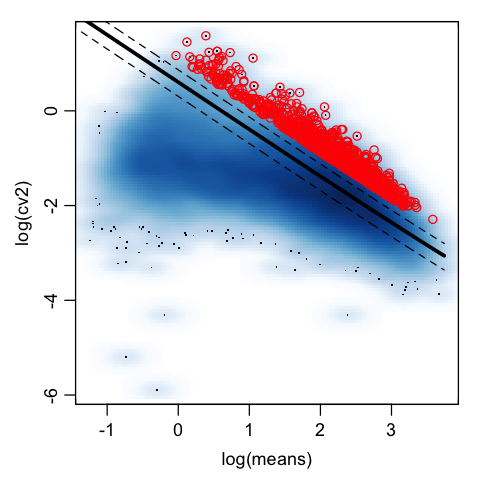

In [12]:
# alpha
options(repr.plot.width=4, repr.plot.height=4)
par(mar=c(3.5,3.5,1,1),mgp=c(2,0.65,0),cex=0.9)
means <- subset(dat.pro_ps.sum,celltype=="alpha")$m
vars <- subset(dat.pro_ps.sum,celltype=="alpha")$vars
cv2 <-subset(dat.pro_ps.sum,celltype=="alpha")$cv2


require(statmod)
minMeanForFit <- unname( quantile( means[ which( cv2 > .3 ) ], .95 ) )
useForFit <- means >= minMeanForFit # & spikeins
fit <- glmgam.fit( cbind( a0 = 1, a1tilde = 1/means[useForFit] ),cv2[useForFit] )
a0 <- unname( fit$coefficients["a0"] )
a1 <- unname( fit$coefficients["a1tilde"])
fit$coefficients

xg <- exp(seq( min(log(means[means>0])), max(log(means)), length.out=1000 ))
vfit <- a1/xg + a0
df <- 99


afit <- a1/means+a0
varFitRatio <- vars/(afit*means^2)
varorder <- order(varFitRatio,decreasing=T)
#oed <- ed[varorder,]
# save for the next exercise
#save(oed,file="oed.RData")

pval <- pchisq(varFitRatio*df,df=df,lower.tail=F)
adj.pval <- p.adjust(pval,"fdr")
sigVariedGenes <- adj.pval<1e-3;
table(sigVariedGenes)



options(repr.plot.width=4, repr.plot.height=4)

par(mar=c(3.5,3.5,1,1),mgp=c(2,0.65,0),cex=0.9); 
smoothScatter(log(means),log(cv2)); 
points(log(means[sigVariedGenes]),log(cv2[sigVariedGenes]),col=2)
lines( log(xg), log(vfit), col="black", lwd=3 );
lines(log(xg),log(vfit * qchisq(0.975,df)/df),lty=2,col="black"); 
lines(log(xg),log(vfit * qchisq(0.025,df)/df),lty=2,col="black");
# add top 100 genes


In [13]:
head(subset(dat.pro_ps.sum,celltype=="alpha")$gene_tr.idx)
head(subset(dat.pro_ps.sum,celltype=="alpha"))

[1] "A1BG_73417"   "A1CF_13523"   "A2ML1_26136"  "A2ML1_26138"  "A3GALT2_2893"
[6] "A4GALT_89082"

gene_tr.idx,celltype,m,vars,cv2
A1BG_73417,alpha,5.5108640,13.14973491,0.43298974
A1CF_13523,alpha,3.3501578,1.05946575,0.09439661
A2ML1_26136,alpha,0.5390679,0.12986534,0.44689591
A2ML1_26138,alpha,0.5403134,0.09665381,0.33107584
A3GALT2_2893,alpha,0.4977617,0.09296425,0.37520887
A4GALT_89082,alpha,0.9633394,0.22148238,0.23866051


In [14]:
dy.glist <- list()
dy.glist[['alpha_tr']] <- subset(dat.pro_ps.sum,celltype=="alpha")$gene_tr.idx[sigVariedGenes]
dy.glist$alpha <- unique(sapply(dy.glist$alpha_tr,function(x) unlist(strsplit(x,split="_"))[1]))

### beta

a0    a1tilde 
0.02528724 0.80064829

sigVariedGenes
FALSE  TRUE 
20601  1223 

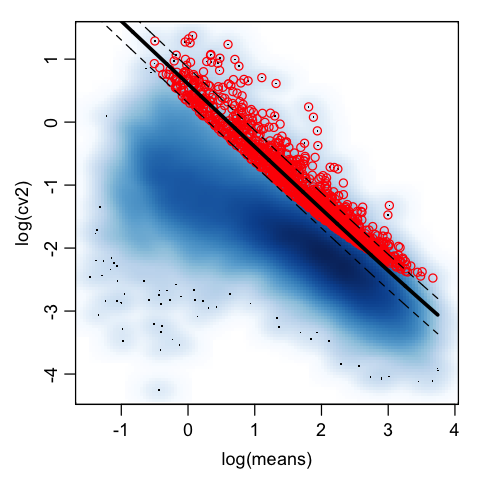

In [16]:
# alpha
options(repr.plot.width=4, repr.plot.height=4)
par(mar=c(3.5,3.5,1,1),mgp=c(2,0.65,0),cex=0.9)
means <- subset(dat.pro_ps.sum,celltype=="beta")$m
vars <- subset(dat.pro_ps.sum,celltype=="beta")$vars
cv2 <-subset(dat.pro_ps.sum,celltype=="beta")$cv2


require(statmod)
minMeanForFit <- unname( quantile( means[ which( cv2 > .3 ) ], .95 ) )
useForFit <- means >= minMeanForFit # & spikeins
fit <- glmgam.fit( cbind( a0 = 1, a1tilde = 1/means[useForFit] ),cv2[useForFit] )
a0 <- unname( fit$coefficients["a0"] )
a1 <- unname( fit$coefficients["a1tilde"])
fit$coefficients

afit <- a1/means+a0
varFitRatio <- vars/(afit*means^2)
varorder <- order(varFitRatio,decreasing=T)





pval <- pchisq(varFitRatio*df,df=df,lower.tail=F)
adj.pval <- p.adjust(pval,"fdr")
sigVariedGenes <- adj.pval<1e-3;
table(sigVariedGenes)

dy.glist[['beta_tr']] <- subset(dat.pro_ps.sum,celltype=="beta")$gene_tr.idx[sigVariedGenes]
dy.glist$beta <- unique(sapply(dy.glist$beta_tr,function(x) unlist(strsplit(x,split="_"))[1]))
                                
      
options(repr.plot.width=4, repr.plot.height=4)
par(mar=c(3.5,3.5,1,1),mgp=c(2,0.65,0),cex=0.9); 
smoothScatter(log(means),log(cv2)); 
points(log(means[sigVariedGenes]),log(cv2[sigVariedGenes]),col=2)
lines( log(xg), log(vfit), col="black", lwd=3 );
lines(log(xg),log(vfit * qchisq(0.975,df)/df),lty=2,col="black"); 
lines(log(xg),log(vfit * qchisq(0.025,df)/df),lty=2,col="black");                               

### compare with binary list 

In [49]:
binary.glist <- readRDS('../dat/1901/binary.glist.Rds')
t(lapply(binary.glist,length))

alpha1_tr,alpha1,alpha2,alpha2_tr,beta1_tr,beta1,beta2,beta2_tr
185,179,1967,2042,182,178,682,696


* most of all alpha binary genes are included in alpha dynamical genes
* 1/3 beta binary genes are not included in dynamical genes 

Loading required package: venn


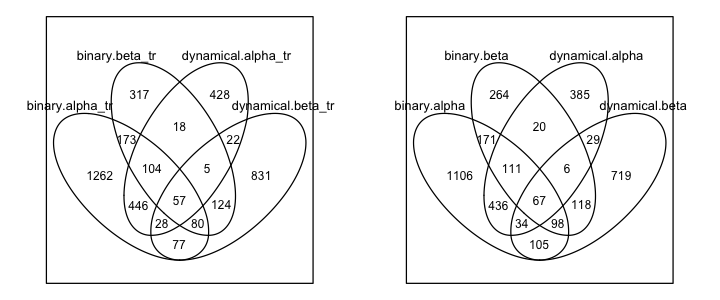

In [53]:
require(venn)
options(repr.plot.width=6, repr.plot.height=2.5)
par(mfrow=c(1,2))
all.list.tr <- list(binary.alpha_tr= c(binary.glist$alpha1_tr,binary.glist$alpha2_tr),
                 binary.beta_tr=c(binary.glist$beta1_tr,binary.glist$beta2_tr),
                 dynamic.alpha_tr=dy.glist$alpha_tr,
                 dynamic.beta_tr=dy.glist$beta_tr)
all.list.gene <- list(binary.alpha= c(binary.glist$alpha1,binary.glist$alpha2),
                 binary.beta=c(binary.glist$beta1,binary.glist$beta2),
                 dynamic.alpha=dy.glist$alpha,
                 dynamic.beta=dy.glist$beta)
venn(all.list.tr,ellipse = T,cexsn =.65 )
venn(all.list.gene,ellipse = T,cexsn = .65)

In [57]:
saveRDS(list(all.list.tr,all.list.gene),file = "../dat/1901/all.list_2.Rds")
saveRDS(dy.glist,file = "../dat/1901/dy.glist.variable.Rds")

## 5. clustering 